Downloading packages

In [64]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from IPython.display import display
import matplotlib.pyplot as plt
import logging
import time
import tqdm

Henter C20 data fra 1996-2024

In [74]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', filename='nasdaq_scraping.log', filemode='w')

# Define the URL with all necessary parameters
url = "https://www.nasdaqomxnordic.com/webproxy/DataFeedProxy.aspx?SubSystem=History&Action=GetChartData&inst.an=id,nm,fnm,isin,tp,chp,ycp&FromDate=1996-08-08&ToDate=2024-08-08&json=true&timezone=CET&showAdjusted=false&app=/visitolur/soguleg_gogn-HistoryChart&DefaultDecimals=false&Instrument=DK0016268840"

# Define headers to mimic a real browser request
headers = {
    'Name': 'Theis Scheuer Jansen',
    'Email': 'Theisscheuerjansen@gmail.com',
    'User-Agent': 'Mozilla/5.0',
    'Referer': 'https://www.nasdaqomxnordic.com/visitolur/soguleg_gogn?languageId=5&Instrument=DK0016268840',
    'Origin': 'https://www.nasdaqomxnordic.com'
}

try:
    # Make the request
    response = requests.get(url, headers=headers, timeout=30)
    time.sleep(1)  # Sleep to avoid overwhelming the server
    
    response.raise_for_status()  # Raise an error for bad status codes
    logging.info("Request successful")
except requests.RequestException as e:
    logging.error(f"Request failed: {e}")
    print(f"Request failed: {e}")

# Extract the 'cp' (closing prices) data from the JSON response
data = response.json()
chart_data = data['data'][0]['chartData']['cp']

# Convert to a pandas DataFrame
C20 = pd.DataFrame(chart_data, columns=['Timestamp', 'Value'])

# Convert the timestamp to a datetime object
C20['Timestamp'] = pd.to_datetime(C20['Timestamp'], unit='ms')

Center C25 data fra x-2024

In [76]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', filename='nasdaq_scraping.log', filemode='w')

# Define the URL with all necessary parameters
url = "https://www.nasdaqomxnordic.com/webproxy/DataFeedProxy.aspx?SubSystem=History&Action=GetChartData&inst.an=id,nm,fnm,isin,tp,chp,ycp&FromDate=2015-08-09&ToDate=2024-08-09&json=true&timezone=CET&showAdjusted=false&app=/indexes/historical_prices-HistoryChart&DefaultDecimals=false&Instrument=DK0060775369"

# Define headers to mimic a real browser request
headers = {
    'Name': 'Theis Scheuer Jansen',
    'Email': 'Theisscheuerjansen@gmail.com',
    'User-Agent': 'Mozilla/5.0',
    'Referer': 'https://www.nasdaqomxnordic.com/visitolur/soguleg_gogn?languageId=5&Instrument=DK0016268840',
    'Origin': 'https://www.nasdaqomxnordic.com'
}

try:
    # Make the request
    response = requests.get(url, headers=headers, timeout=30)
    time.sleep(1)  # Sleep to avoid overwhelming the server
    
    response.raise_for_status()  # Raise an error for bad status codes
    logging.info("Request successful")
except requests.RequestException as e:
    logging.error(f"Request failed: {e}")
    print(f"Request failed: {e}")

# Extract the 'cp' (closing prices) data from the JSON response
data = response.json()
chart_data = data['data'][0]['chartData']['cp']

# Convert to a pandas DataFrame
C25 = pd.DataFrame(chart_data, columns=['Timestamp', 'Value'])

# Convert the timestamp to a datetime object
C25['Timestamp'] = pd.to_datetime(C25['Timestamp'], unit='ms')

#Generate a complete date range from October 1, 1996, to August 8, 2024, including weekends
full_date_range = pd.date_range(start='1996-10-01', end='2024-08-08', freq='D')

# Reindex the DataFrame to include the full date range, filling in missing dates
C25.set_index('Timestamp', inplace=True)
C25 = C25.reindex(full_date_range)

# Forward fill missing data to handle weekends and holidays
C25['Value'] = C25['Value'].ffill()

# Reset the index to include 'Timestamp' as a column again
C25.reset_index(inplace=True)
C25.rename(columns={'index': 'Timestamp'}, inplace=True)

# Forward fill missing data to handle weekends and holidays
C25['Value'] = C25['Value'].ffill()



Data Rens + tilføjer valgdata

Tilføj data fra 1990-1994 (okt) fra https://tradingeconomics.com/kfx:ind lukkedatoen er for sidste dag i måneden

In [81]:
# Generate a complete date range from October 1, 1996, to August 8, 2024, including weekends
full_date_range = pd.date_range(start='1996-10-01', end='2024-08-08', freq='D')

# Reindex the DataFrame to include the full date range, filling in missing dates
C20.set_index('Timestamp', inplace=True)
C20 = C20.reindex(full_date_range)

# Forward fill missing data to handle weekends and holidays
C20['Value'] = C20['Value'].ffill()

# Reset the index to include 'Timestamp' as a column again
C20.reset_index(inplace=True)
C20.rename(columns={'index': 'Timestamp'}, inplace=True)

# Define election dates
election_dates = [
    '1998-03-11',
    '2001-11-20',
    '2005-02-08',
    '2007-11-13',
    '2011-09-15',
    '2015-06-18',
    '2019-06-05',
    '2022-11-01'
]

# Convert election dates to datetime objects
election_dates = pd.to_datetime(election_dates)

# Add a new column 'Election' to indicate whether the row is an election date
C20['Election'] = C20['Timestamp'].isin(election_dates)

# Create a list to define the periods of "Rød" and "Blå"
periods = [
    ('1994-10-01', '1994-09-20', 'Blå'),
    ('1994-09-21', '2001-11-19', 'Rød'),
    ('2001-11-20', '2011-09-14', 'Blå'),
    ('2011-09-15', '2015-06-17', 'Rød'),
    ('2015-06-18', '2019-06-04', 'Blå'),
    ('2019-06-05', '2024-08-08', 'Rød')
]

# Initialize the new column
C20['Color'] = pd.NA

# Assign "Rød" or "Blå" based on the defined periods
for start, end, color in periods:
    C20.loc[(C20['Timestamp'] >= start) & (C20['Timestamp'] <= end), 'Color'] = color

# Forward fill missing data to handle weekends and holidays
C20['Value'] = C20['Value'].ffill()



Plotting

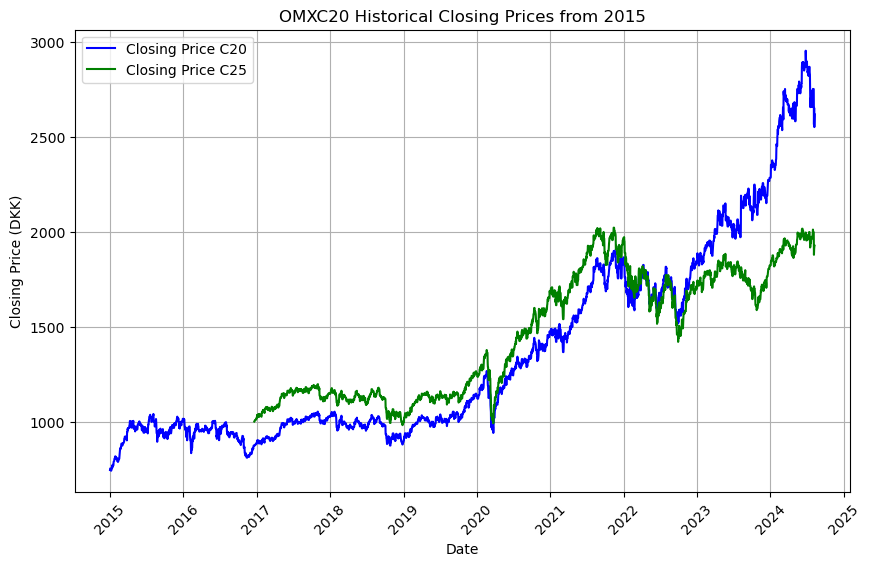

In [83]:
# Filter the data to start from 01/01/2015
start_date = pd.to_datetime('2015-01-01')
C20_filtered = C20[C20['Timestamp'] >= start_date]
C25_filtered = C25[C25['Timestamp'] >= start_date]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(C20_filtered['Timestamp'], C20_filtered['Value'], label='Closing Price C20', color='blue')
plt.plot(C25_filtered['Timestamp'], C25_filtered['Value'], label='Closing Price C25', color='green')

# Adding titles and labels
plt.title('OMXC20 Historical Closing Prices from 2015')
plt.xlabel('Date')
plt.ylabel('Closing Price (DKK)')

# Formatting the date on the x-axis for better readability
plt.xticks(rotation=45)

# Adding a grid
plt.grid(True)

# Display the legend
plt.legend()

# Show the plot
plt.show()


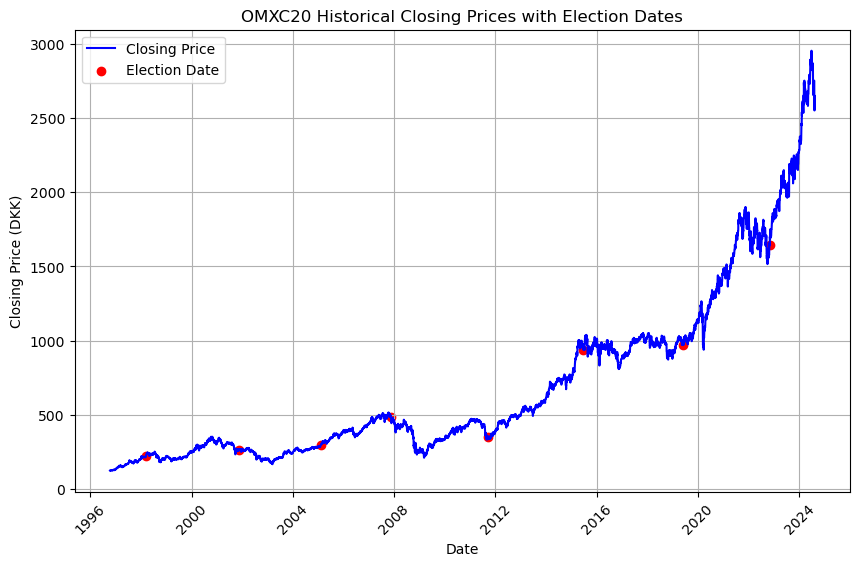

In [84]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(C20['Timestamp'], C20['Value'], label='Closing Price', color='blue')

# Highlight election dates
election_points = C20[C20['Election']]

plt.scatter(election_points['Timestamp'], election_points['Value'], color='red', label='Election Date')

# Adding titles and labels
plt.title('OMXC20 Historical Closing Prices with Election Dates')
plt.xlabel('Date')
plt.ylabel('Closing Price (DKK)')

# Formatting the date on the x-axis for better readability
plt.xticks(rotation=45)

# Adding a grid
plt.grid(True)

# Display the legend
plt.legend()

# Show the plot
plt.show()


Beregning af fkast

In [85]:
# Rename the DataFrame from C20 to data
data = C20

# Ensure 'Timestamp' is set as the index for proper time series operations
data.set_index('Timestamp', inplace=True)

# Resample the data to get the last closing price of each month
monthly_data = data['Value'].resample('M').last()

# Calculate the monthly returns
data['Monthly Return'] = monthly_data.pct_change()

# Calculate direct returns for 1, 3, 6, 9, and 12 months before each election date
data['Return_3M'] = pd.NA
data['Return_6M'] = pd.NA
data['Return_9M'] = pd.NA
data['Return_12M'] = pd.NA

for date in election_dates:
    if date in data.index:
        data.loc[date, 'Return_3M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=3), 'Value'] - 1) * 100
        data.loc[date, 'Return_6M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=6), 'Value'] - 1) * 100
        data.loc[date, 'Return_9M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=9), 'Value'] - 1) * 100
        data.loc[date, 'Return_12M'] = (data.loc[date, 'Value'] / data.loc[date - pd.DateOffset(months=12), 'Value'] - 1) * 100

# Reset the index to include 'Timestamp' as a column again
data.reset_index(inplace=True)

Data for valg og afkast før valg

In [86]:
# Filtrer DataFrame for kun at inkludere rækker, hvor 'Election' er True
election_data = data[data['Election']]

# Juster displayindstillingerne
pd.set_option('display.max_columns', None)  # Vis alle kolonner
pd.set_option('display.expand_frame_repr', False)  # Forhindr brud på linjer
pd.set_option('display.max_colwidth', None)  # Vis fulde kolonnebredder

# Udskriv DataFrame
display(election_data)

# Eksporter til Excel
election_data.to_excel('election_data.xlsx', index=False)


,Timestamp,Value,Election,Color,Monthly Return,Return_3M,Return_6M,Return_9M,Return_12M
526,1998-03-11,222.44,True,Rød,NaN,10.948177,26.999715,30.639572,37.759336
1876,2001-11-20,267.33,True,Blå,NaN,-10.812704,-13.683769,-20.138018,-17.160918
3052,2005-02-08,301.06,True,Blå,NaN,7.717629,13.023238,18.939633,11.06766
4060,2007-11-13,486.84,True,Blå,NaN,0.335937,-0.644898,1.513825,14.485937
5462,2011-09-15,349.32,True,Rød,NaN,-19.138889,-22.24374,-22.62266,-16.183986
6834,2015-06-18,941.18,True,Blå,NaN,3.451384,26.422824,22.210536,26.385476
8282,2019-06-05,973.31,True,Rød,NaN,-2.144494,4.77754,-1.940417,-1.571522
9527,2022-11-01,1647.03,True,Rød,NaN,-8.759383,-7.804305,-2.48548,-11.066054
